# Practical Case with Custom Functions and the MNIST Dataset

In this tutorial, we introduce a custom feature using the MNIST dataset as a more practical example. If you're new to QXMT, it is recommended to start with the "[Simple Case Using Only the Default Dataset and Model](https://qyusu.github.io/qxmt/tutorials/en/default_simple.html#)" tutorial to gain an overall understanding.

## 1. Preparing the Dataset
To begin managing experiments, the MNIST dataset must be downloaded. Major datasets, including MNIST, can be easily downloaded using the `scikit-learn` method [fetch_openml](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html).

In this tutorial, the dataset used for the experiment is downloaded manually, but QXMT also provides a feature to download major datasets from [OpenML](https://www.openml.org/) via a config file. For more details, refer to the tutorial that demonstrates how to use OpenML.

In [6]:
import os
import numpy as np
from sklearn import datasets

# Load MNIST784 dataset
digits_dataset = datasets.fetch_openml("mnist_784")
print(f"Dataset Shape: {digits_dataset.data.shape}")
print(f"Unique Label Number: {len(np.unique(digits_dataset.target))}")

# convert to numpy array
X = digits_dataset.data.to_numpy()
y = digits_dataset.target.to_numpy()

# create a directory to save dataset
os.makedirs("../data/mnist_784", exist_ok=True)

# save dataset on local environment
np.save("../data/mnist_784/dataset_X.npy", X)
np.save("../data/mnist_784/dataset_y.npy", y)

Dataset Shape: (70000, 784)
Unique Label Number: 10


## 2. Implementing Custom Features

In QXMT, custom features can be defined in the following five categories:

- **Dataset**: Preprocessing logic (`raw_preprocess_logic`) for filtering and removing outliers from the loaded dataset can be defined, along with transformation logic (`transform_logic`) for tasks like discretization and dimensionality reduction.
- **Feature Map**: Custom feature maps can be defined as functions or quantum circuits.
- **Kernel**: Custom kernel functions can be defined.
- **Model**: Custom quantum machine learning models can be defined.
- **Evaluation**: Custom evaluation metrics can be defined and tracked as logs for each experiment.

This tutorial demonstrates how to implement and manage experiments in QXMT using three commonly used features: `Dataset`, `Feature Map`, and `Evaluation`. Other features can be similarly implemented, invoked, and managed, allowing for further exploration of those options.

### 2.1 Custom Definition of Dataset Processing Logic
For the dataset, two types of logic can be independently defined: preprocessing logic and transformation logic.

We will first address the implementation of the preprocessing logic. This involves filtering the MNIST dataset to focus on specific labels from the ten total classes. Additionally, due to the significant computational complexity of quantum kernels, functionality to reduce the sample size of the data is also included.

In [24]:
# File: ../custom/raw_preprocess_logic.py

import numpy as np


def sampling_by_each_class(
    X: np.ndarray, y: np.ndarray, n_samples: int, labels: list[int]
) -> tuple[np.ndarray, np.ndarray]:

    y = np.array([int(label) for label in y])
    indices = np.where(np.isin(y, labels))[0]
    X, y = X[indices][:n_samples], y[indices][:n_samples]

    return X, y

Next, the transformation logic for the data will be implemented. In this step, PCA is used to perform dimensionality reduction on the input data. Since each MNIST image consists of 784 dimensions, the required number of qubits can be substantial. Therefore, the data is compressed using the `n_components` parameter to a manageable size based on the computing environment being used.

In [25]:
# File: ../custom/transform_logic.py

from typing import Optional

import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def dimension_reduction_by_pca(
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: Optional[np.ndarray],
    y_val: Optional[np.ndarray],
    X_test: np.ndarray,
    y_test: np.ndarray,
    n_components: int,
) -> tuple[np.ndarray, np.ndarray, Optional[np.ndarray], Optional[np.ndarray], np.ndarray, np.ndarray]:
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val) if X_val is not None else None
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=n_components)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled) if X_val_scaled is not None else None
    X_test_pca = pca.transform(X_test_scaled)

    return X_train_pca, y_train, X_val_pca, y_val, X_test_pca, y_test

### 2.2 Custom Definition of Feature Map

QXMT provides basic feature maps, such as those constructed with Rotation Gates and the ZZFeatureMap, which can be used directly by specifying them in the configuration. However, in practical applications and research, more complex feature maps are often needed. Therefore, QXMT allows the implementation of custom feature maps that can be invoked via the configuration. This approach makes it easier to experiment with different feature map designs.

In this tutorial, a quantum circuit using PennyLane is implemented as a feature map, applying the ZZFeatureMap followed by the XXFeatureMap. When defining a custom feature map, it is important to inherit from the abstract class `qxmt.feature_maps.BaseFeatureMap` to ensure compatibility and take advantage of QXMT's various functionalities. If creating a class for each feature map is too cumbersome, you can also pass a function that implements the FeatureMap to the Kernel class. For more details, please refer to the API Reference.

In [26]:
# File: your_project/custom/feature_map.py

import numpy as np
import pennylane as qml

from qxmt.feature_maps import BaseFeatureMap


class CustomFeatureMap(BaseFeatureMap):
    def __init__(self, n_qubits: int, reps: int) -> None:
        super().__init__("pennylane", n_qubits)
        self.reps: int = reps

    def feature_map(self, x: np.ndarray) -> None:
        for _ in range(self.reps):
            for i in range(self.n_qubits):
                qml.Hadamard(wires=i)
                qml.RZ(x[i], wires=i)
            for i in range(0, self.n_qubits - 1):
                qml.IsingZZ(2 * (np.pi - x[i]) * (np.pi - x[i + 1]), wires=[i, i + 1])

        for _ in range(self.reps):
            for i in range(self.n_qubits):
                qml.RX(x[i], wires=i)
            for i in range(0, self.n_qubits - 1):
                qml.IsingXX(2 * (np.pi - x[i]) * (np.pi - x[i + 1]), wires=[i, i + 1])

### 2.3 Custom Definition of Evaluation Metrics

In this section, we will define a custom evaluation metric. While default metrics such as Accuracy, Precision, Recall, and F-Measure are provided, additional evaluation metrics are often required depending on specific goals. In such cases, you can manage experiments in the same way as with the default metrics using the method introduced here.

In this tutorial, we will define specificity as an additional evaluation metric. When defining a custom evaluation metric, it should be implemented as a class that inherits from `qxmt.evaluation.BaseMetric`, and the logic for calculating the evaluation value should be implemented in the `evaluate` method.

In [27]:
# File: your_project/custom/evaluation.py

from typing import Any

import numpy as np
from sklearn.metrics import confusion_matrix

from qxmt.evaluation.metrics import BaseMetric


class CustomMetric(BaseMetric):
    def __init__(self) -> None:
        super().__init__("specificity")

    @staticmethod
    def evaluate(actual: np.ndarray, predicted: np.ndarray, **kwargs: Any) -> float:
        tn, fp, fn, tp = confusion_matrix(actual, predicted).ravel()
        return tn / (tn + fp)

The implementation of custom logic for the dataset, feature map, and evaluation metrics has been completed. The implemented logic can accept various parameters, which can be configured through the Run's configuration, enabling easy execution of experiments under different conditions. More details will be introduced in Chapter 3.

## 3. Configuring Run Settings

This section explains the items that need to be configured in the configuration file to utilize the implemented custom methods. Areas that require additional configuration are marked with the `[SETUP]` tag. The primary configuration method involves specifying the path to the module where the custom logic is implemented, along with the function or class name. Parameters for each can also be documented under `params`, allowing them to be passed as arguments during execution.

```yaml
# File: your_project/configs/custom.yaml

description: "Configuration file for the custom MNIST case"

global_settings:
  random_seed: &global_seed 42
  task_type: "classification"

dataset:
  file: # [SETUP] full path or relative path from the root of the project
    data_path: "data/mnist_784/dataset_X.npy"
    label_path: "data/mnist_784/dataset_y.npy"
    label_name: null
  random_seed: *global_seed
  split:
    train_ratio: 0.8
    validation_ratio: 0.0
    test_ratio: 0.2
    shuffle: true
  features: null
  raw_preprocess_logic: # [SETUP] your logic path and parameter
    module_name: "your_project.custom.raw_preprocess_logic"
    implement_name: "sampling_by_each_class"
    params:
        n_samples: 100
        labels: [0, 1]
  transform_logic: # [SETUP] your logic path and parameter
    module_name: "your_project.custom.transform_logic"
    implement_name: "dimension_reduction_by_pca"
    params:
        n_components: 2

device:
  platform: "pennylane"
  name: "default.qubit"
  n_qubits: 2
  shots: null

feature_map: # [SETUP] your logic path and parameter
  module_name: "your_project.custom.feature_map"
  implement_name: "CustomFeatureMap"
  params:
    reps: 2

kernel:
  module_name: "qxmt.kernels.pennylane"
  implement_name: "FidelityKernel"
  params: {}

model:
  name: "qsvc"
  file_name: "model.pkl"
  params:
    C: 1.0
    gamma: 0.05

evaluation: # [SETUP] your logic path
  default_metrics:
  - "accuracy"
  - "precision"
  - "recall"
  - "f1_score"
  custom_metrics: 
  - {"module_name": "your_project.custom.evaluation", "implement_name": "CustomMetric"}
```

## 4. Executing Experiments and Evaluation
Finally, an instance of the QXMT experiment management system will be created, and the previously defined configuration file will be used to execute the Run.

If an module import error occurs during execution, review the Python path and re-run the process.
For example, if a custome module is implemented in `/root/hoge/your_project/custom/raw_preprocess_logic.py`, the Python path can be updated using the `sys.path.append("/root/hoge")` command.

In [1]:
import qxmt

# initialize experiment for custom tutorial
experiment = qxmt.Experiment(
    name="custom_tutorial",
    desc="A custome experiment for MNIST dataset",
    auto_gen_mode=False,
).init()

In [2]:
import sys
from pathlib import Path

# add module path for python execution
module_path = Path.cwd().resolve().parents[1]
if module_path not in sys.path:
    sys.path.append(str(module_path))

In [3]:
# execute run of custom method
config_path = "../configs/custom.yaml"
artifact, result = experiment.run(config_source=config_path)

# check evaluation result
metrics_df = experiment.runs_to_dataframe()
metrics_df.head()

Output()

Output()

,run_id,accuracy,precision,recall,f1_score,specificity
0,1,0.6,0.666667,0.666667,0.666667,0.5


The results of the experiment, including the custom-defined evaluation metrics, will be visualized.

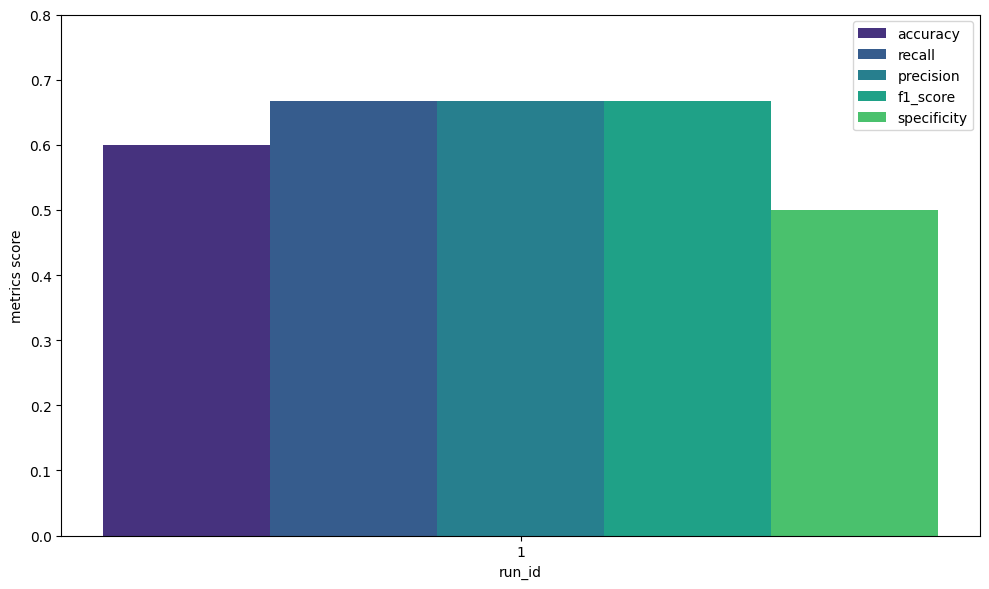

In [4]:
from qxmt.visualization import plot_metrics_side_by_side

# get run result as dataframe
df = experiment.runs_to_dataframe()

# add your custom metrics on metrics list
plot_metrics_side_by_side(
  df=df,
  metrics=["accuracy", "recall", "precision", "f1_score", "specificity"],
  run_ids=[1],
  save_path=experiment.experiment_dirc / "side_by_side.png"
  )

---

### Version Information
| Environment | Version |
|----------|----------|
| document | 2024/11/22 |
| QXMT| v0.3.5 |